In [1]:
# The duration of data that is being cleaned and is to be stored
period_of_data_cleaned = '16_17' # format = 'year' ; for 2017 : '2017'

In [2]:
#path to write pickle file(single zone data frame) to.
path_for_writing = '/mnt/home/lp_pr/Results_Final2/'  
from pprint import pprint
# Path for reading the CSV files from.
path_for_reading = '/home/lp_pr/Integrated Load/load/' 
path_for_reading_weather = '/home/lp_pr/Weather/'
path_for_results = '/home/lp_pr/Results_Final2/'

In [5]:
#Importing print function for compatability with python 3.

from __future__ import print_function

# Importing required libraries.

import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
import os
import pickle
import matplotlib.pyplot as plt
import calendar
#import algorithms
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR,SVC
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import check_array
import datetime
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.utils import check_array
from multiprocessing import Pool,cpu_count
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from xgboost import XGBRegressor
from skgarden import MondrianTreeRegressor


ModuleNotFoundError: No module named 'keras'

In [4]:
#dictionary of all algorithms to be used 
all_models = {'gb': XGBRegressor()
    #'gb' : MondrianTreeRegressor()
#               'rf' : RandomForestRegressor(),
#               'etrees' : ExtraTreesRegressor(),
             }

# List of all zones
all_zones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL',
             'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']

NameError: name 'XGBRegressor' is not defined

In [5]:
#Defining holidays
months = [1,2,9,10,11,12]
years = [2012,2013,2014,2015,2016,2017]
numbers = [1,7,6,5,4,3,2]
pres_day, labor_day,columbus_day,thanksgiving_day = [], [], [], []
hols = []
for i in years:
    pres_day.append(14 + numbers[datetime.datetime(i,2,1).weekday()])
    columbus_day.append(7 + numbers[datetime.datetime(i,10,1).weekday()])
    labor_day.append(datetime.datetime(i,9,1).day + numbers[datetime.datetime(i,9,1).weekday()] - 1)
pres_day = pres_day + [2]
columbus_day = columbus_day + [9]
labor_day = labor_day + [10]
numbers = [4,3,2,1,7,6,5]
for i in years:
    thanksgiving_day.append(21 + numbers[datetime.datetime(i,11,1).weekday()])
thanksgiving_day = thanksgiving_day + [11]
hols.append([1,1,1,1,1,1] + [1])
hols.append(pres_day)
hols.append(labor_day)
hols.append(columbus_day)
hols.append(thanksgiving_day)
hols.append([25,25,25,25,25,25] + [12])

keys = ['new_year','pres_day','lab_day','col_day','thanks_day','chris']
hols = {key: hols[index] for index,key in enumerate(keys)}

In [6]:
# Function to load all data into a dataframe 
def load_data(monthly_files):
    df = pd.DataFrame(columns=['Time Stamp','Time Zone', 'Name','PTID','Integrated Load'])

    for file_name in monthly_files:
        if '.' not in file_name:
            files = os.listdir(path_for_reading+ file_name)
            files.sort()
            for day_file in files:
                try:
                    temp_df = pd.read_csv(path_for_reading+ file_name +'/'+day_file)
                    df = df.append(temp_df,ignore_index=True)
                except:
                    print(f'Error in {day_file}')
                    print("hi")
    return df 

In [7]:
# funcion to take the raw loaded data and return the final form of dataframe required with split timestamps
def clean_data(df):
    # Create columns for each of the load zones with their respective loads in place for a given time stamp
    all_zones = df.Name.unique()
    
    for zone in all_zones:
        df[zone] = (df.Name == zone).astype(int)
        df[zone] = df[zone] * df['Integrated Load']
    
    # Group using Time stamp and drop the unnecessary columns and reset the index of the dataframe
    df = df.drop(['PTID','Time Zone'],axis=1).groupby('Time Stamp',sort = False).sum().drop('Integrated Load',axis=1).reset_index()

    # Separation of Time Stamp
    df['Week_number'] = pd.to_datetime(df['Time Stamp']).dt.week
    df['dayofweek'] = pd.to_datetime(df['Time Stamp']).dt.dayofweek
    df['Year'] = pd.DatetimeIndex(df['Time Stamp']).year
    df['Month'] = pd.DatetimeIndex(df['Time Stamp']).month
    df['Day'] = pd.DatetimeIndex(df['Time Stamp']).day
    df['Hour'] = pd.DatetimeIndex(df['Time Stamp']).hour
    df = df.drop('Time Stamp',axis=1)
    df['Weekends'] = ((df.dayofweek == 5) | (df.dayofweek == 6)).astype(int)

    # All-Zone load data for the month with time stamp
    with open(path_for_writing + 'NYC'.format(period_of_data_cleaned),'wb') as f:
        pickle.dump(df,f)
    return df

In [8]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
#     print(y_pred.shape)
    return (np.mean(np.abs(((y_true - y_pred) / y_true)) * 100))

In [9]:
def prev_day(day,month):
    if day!=1:
        prevday=day-1;
    else:
        if month==1:
            prevday=days_in_month(12);
        else:
            prevday=days_in_month(month-1);
    return prevday

In [10]:
# function to calculate the results for all zones  for a year for all algorithms. 
# Returns a dictionary with months as keys and the results for each month as dataframe

def yearly_results(data, zone, year, train_interval,history):
    final_results_mae = {}
    final_results_mape = {}
    r2_graph= []
    mape_graph = []
    for i in range(1,13) : 
        final_results_mae[i] = {}
        final_results_mape[i] = {}
    for month_ in range(1,13):
        mape_dict = { 'gb' : []
                    }
        mae_dict  = { 'gb' : []
                    }
        for test_day in range(1,days_in_month(month_)+1):
            if (not(test_day == 28) & (month_ == 1) & (year == 2016)):
#             print('date : {}-{}-{}'.format(test_day,month_,year))
                X_train,y_train,X_test,y_test = get_train_test_vectors(data,zone,test_day,month_,year,train_interval,history)
    #             print(y_train.isnull().sum())
    #             print(len((X_train)),len((ytrain)),len((xtest)),len((ytest))) 
                mape_dict,mae_dict,flag_for_r2,score,error = fit_predict_mape_all_models(X_train, X_test, y_train, y_test,mape_dict,mae_dict)
                r2_graph.append(score)
                mape_graph.append(error)
                if(flag_for_r2 == True):
                    print('date : {}-{}-{}'.format(test_day,month_,year))

        for model in all_models.keys():
            mape_dict[model] = (sum(mape_dict[model])/len(mape_dict[model]))
            mae_dict[model] = (sum(mae_dict[model])/len(mae_dict[model]))            
        final_results_mae[month_] = mae_dict
        final_results_mape[month_] = mape_dict
    return final_results_mape,final_results_mae,r2_graph,mape_graph

In [73]:
#Trial run for proper history
def get_train_test_vectors(df, zone_name, test_day, test_month, test_year, train_interval,history):
    X_train= pd.DataFrame()
    y_train = pd.DataFrame()
    X_test = df[['Day','Hour','Month','Year','FeelsLikeC','Weekends','Seasons']][(df.Day == test_day) & (df.Month == test_month) & (df.Year==test_year)]
    y_test = df['{}'.format(zone_name)][(df.Day == test_day) & (df.Month == test_month) & (df.Year==test_year)]

    #Training for train_inteval days before the test_day
    day_variable = 1
    day = test_day
    month = test_month
    year = test_year
    for train_time in range(1,train_interval+1):
        day -= 1
        if(day > 0):
            pass
        else:
            year, month = (test_year-1, 12) if (month == 1) else (test_year, test_month-1)
            day = days_in_month(month) + 1 - train_time
        for hol in hols.values():
            if ((month == hol[6]) & (day == hol[years.index(year)])):
                continue_var = True
            else:
                continue_var = False
        if continue_var:
            continue    
        X_train = pd.concat([X_train.reset_index(drop=True),df[['Day','Hour','Month','Year','FeelsLikeC','Weekends','Seasons']][(df.Day == day) & (df.Month == month) & (df.Year == year)]])
        y_train = pd.concat([y_train.reset_index(drop=True),df['N.Y.C.'][(df.Day == day) & (df.Month == month) & (df.Year==year)].reset_index(drop=True)])
    #Add 1 year of history only for normal days    
    if (not continue_var):
        X_train = pd.concat([X_train.reset_index(drop=True),df[['Day','Hour','Month','Year','FeelsLikeC','Weekends','Seasons']][(df.Year == test_year-1)]])
        y_train = pd.concat([y_train.reset_index(drop=True), df['N.Y.C.'][(df.Year == test_year-1)&(df.Day == day) & (df.Month == month)].reset_index(drop=True)])
    
    #Train separately for holidays with only past holidays as history
    indx = years.index(test_year)
    for i in hols:
        if ((test_day == hols[i][indx]) & (test_month == hols[i][6])):
            for j in range(2012,test_year):
                X_train = pd.concat([X_train.reset_index(drop=True), df[['Day','Hour','Month','Year','FeelsLikeC','Weekends','Seasons']][(df.Year == j) & (df.Month == hols[i][6]) & (df.Day == hols[i][years.index(j)])]])
                y_train = pd.concat([y_train.reset_index(drop=True), df['N.Y.C.'][(df.Year == j) & (df.Month == hols[i][6]) & (df.Day == hols[i][years.index(j)])].reset_index(drop=True)])        
            return X_train,y_train,X_test,y_test        
    
    y_train = y_train.reset_index(drop=True)
    X_train = X_train.reset_index(drop=True)    
    return X_train,y_train,X_test,y_test

In [12]:
def days_in_month(month):
    
    if month in [1,3,5,7,8,10,12]:
        end_day=31
    elif month in [4,6,9,11]:
        end_day=30
    elif month==2:
        end_day=28
    return end_day

In [13]:
# Function to Train and test all models

def fit_predict_mape_all_models(X_train,X_test,y_train,y_test,mape,mae):               
    for model in all_models.keys():
        regressor = all_models[model]
#         print(len(np.ravel(y_train)))
#         print(y_train.isnull())
        regressor.fit(X_train,np.ravel(y_train))
        predicted_values = regressor.predict(X_test)
        r2= r2_score(y_test,predicted_values)
        error = mean_absolute_percentage_error(y_test,predicted_values)
        if((r2>=0)):
            mae[model].append(mean_absolute_error(y_test,predicted_values)) 
            mape[model].append(mean_absolute_percentage_error(y_test,predicted_values)) 
        else:
            predicted_values = pd.DataFrame(predicted_values)
            #plt.plot(y_test.reset_index(drop=True),'b')
            #plt.plot(predicted_values.reset_index(drop=True),'r')
            #plt.show()

# Plot y_test & predicted values
        #flag= False
        print('R^2 : {}'.format(r2_score(y_test,predicted_values)))
        flag = True
#         plt.plot(y_test.reset_index(drop=True),'b')
#         plt.plot(predicted_values.reset_index(drop=True),'r')
#         plt.show()
    return mape,mae,flag,r2,error

In [74]:
# Function to get final results and store

def get_and_store_results(inp):
    year= 2017
    df,train_interval,history = inp
    complete_results_mape= {}
    complete_results_mae= {}    
    for zone_name in ['N.Y.C.']:
        print("Getting results for {}...".format(zone_name))
        complete_results_mape[zone_name],complete_results_mae[zone_name] ,r2_graph,mape_graph= yearly_results(df,zone_name,year,train_interval,history)
    print("Completed.")
#     plt.plot(r2_graph,'b')
#     plt.plot(mape_graph,'r')
#     plt.show()

    
#     Results for 14 days training and 1 day testing for 2017, all zones, 7 algorithms, stored in 'Results_2017.xlsx'
    writer = pd.ExcelWriter(path_for_writing+'test123.xlsx'.format(year,train_interval))
    for zone_name in ['N.Y.C.']:
        pd.DataFrame(complete_results_mape[zone_name]).to_excel(writer,sheet_name = 'MAPE_{}'.format(train_interval))
        pd.DataFrame(complete_results_mae[zone_name]).to_excel(writer,sheet_name = 'MAE_{}'.format(train_interval))
    writer.save()
    
   
    return complete_results_mape,complete_results_mae

In [11]:
get_and_store_results(df,7)

In [52]:
# #ONLY RUN WHEN CITY NEEDS TO BE CHANGED


# # Store all the files for the month as a sorted list.
# monthly_files = os.listdir(path_for_reading)
# monthly_files.sort()

# #Get temperature and humidity data, remove 2 a.m. data to match with load data
# weather_df = pd.DataFrame()
# for i in range(2012,2018):
#     weather_df = weather_df.append(pd.read_csv('/home/lp_pr/Weather/weather_all_'+'{}'.format(i),index_col=0))
# weather_df.drop([1682,10418,19154,27890,36794,45530],axis = 0,inplace=True)
# weather_df.reset_index(drop=True,inplace = True)

# # call functions to load and clean data, keep only NYC
# df = load_data(monthly_files)
# df = clean_data(df)
# df = df.drop(['CAPITL','CENTRL','DUNWOD','GENESE','HUD VL', 'LONGIL', 'MHK VL', 'WEST', 'NORTH', 'MILLWD'], axis=1)
# df = df.drop(['Name','Unnamed: 0','Unnamed: 1'],axis=1)
# df.reset_index(drop=True, inplace = True)

# #Concatenate temperature and humidity
# test_df = pd.concat([df, weather_df.Temperature,weather_df.Humidity,weather_df.DewPoint,weather_df.FeelsLikeC,weather_df.WindChillC,weather_df.WindspeedKmph,weather_df.cloudcover], axis = 1)
# #Pickle temp+humidity+load for NYC
# test_df.drop([35730],axis = 0, inplace = True)
# test_df.reset_index(drop=True, inplace = True)
# print("Concatenated temperature and load")
# #Pickle temp+humidity+load for NYC
# with open(path_for_writing + 'data_for_NYC_new','wb') as f:
#     pickle.dump(test_df,f)

In [15]:
#Pickle df for mentioned city
with open('/mnt/home/lp_pr/Results/data_for_NYC_seasons','rb') as f:
    df=pickle.load(f)

In [152]:
corr_df = df[['N.Y.C.','Temperature','Humidity', 'DewPoint', 'FeelsLikeC', 'WindChillC','WindspeedKmph', 'cloudcover']]

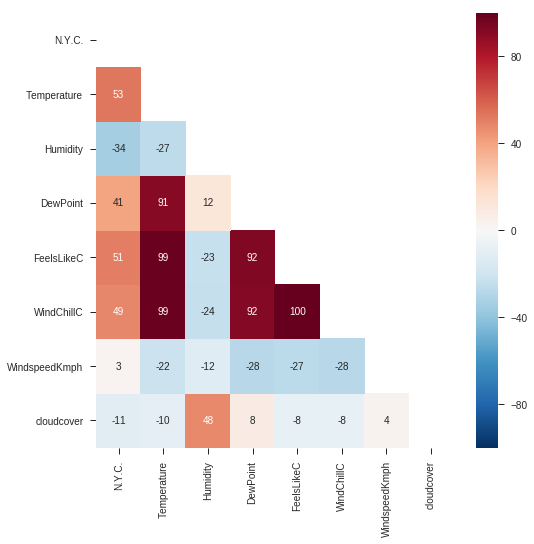

In [153]:
correlations = corr_df.corr()
# correlations
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,8))
sns.heatmap(correlations*100,mask = mask, annot = True, fmt = '.0f', cbar = True)
sns.set_style("ticks")

In [18]:
#plt.plot(df['N.Y.C.'][(df.Year == 2012) & (df.Month == 5) & (df.Day == 28)].reset_index(drop=True),'r')
#plt.plot(df['N.Y.C.'][(df.Year == 2013) & (df.Month == 5) & (df.Day == 27)].reset_index(drop=True),'b')
#plt.plot(df['N.Y.C.'][(df.Year == 2014) & (df.Month == 5) & (df.Day == 26)].reset_index(drop=True),'g')
#plt.plot(df['N.Y.C.'][(df.Year == 2015) & (df.Month == 5) & (df.Day == 25)].reset_index(drop=True),'o')
#plt.plot(df['N.Y.C.'][(df.Year == 2016) & (df.Month == 5) & (df.Day == 30)].reset_index(drop=True))
# plt.plot(df['N.Y.C.'][(df.Year == 2014) & (df.Month == 12) & (df.Day == 25)].reset_index(drop=True),'b')
# plt.plot(df['N.Y.C.'][(df.Year == 2015) & (df.Month == 12) & (df.Day == 25)].reset_index(drop=True),'g')
# plt.plot(df['N.Y.C.'][(df.Year == 2016) & (df.Month == 12) & (df.Day == 25)].reset_index(drop=True),'y')
# plt.plot(df['N.Y.C.'][(df.Year == 2017) & (df.Month == 12) & (df.Day == 25)].reset_index(drop=True))
# plt.plot(df['N.Y.C.'][(df.Year == 2014) & (df.Month == 12) & (df.Day == 25)].reset_index(drop=True))
# plt.plot(df['N.Y.C.'][(df.Year == 2015) & (df.Month == 12) & (df.Day == 25)].reset_index(drop=True))
# plt.plot(df['N.Y.C.'][(df.Year == 2016) & (df.Month == 12) & (df.Day == 25)].reset_index(drop=True))
# plt.plot(df['N.Y.C.'][(df.Year == 2017) & (df.Month == 12) & (df.Day == 25)].reset_index(drop=True),'b')
#plt.show()


In [23]:
result = []
params = []
# for i in range(1,15):
params.append((df,7,0))

In [75]:
pool = Pool(cpu_count()-1)
try:
    pool.map(get_and_store_results,params)
except Exception as e:
    print(e)
finally:
    pool.close()
    pool.join()

Getting results for N.Y.C....
R^2 : 0.9298293362690921
date : 1-1-2017
R^2 : 0.3543809639113563
date : 2-1-2017
R^2 : 0.5182489398360316
date : 3-1-2017
R^2 : 0.963277487851081
date : 4-1-2017
R^2 : 0.6429359178587634
date : 5-1-2017
R^2 : 0.9852144565699295
date : 6-1-2017
R^2 : 0.8187082582378508
date : 7-1-2017
b'[14:13:33] src/objective/regression_obj.cc:90: Check failed: (preds.size()) == (info.labels.size()) labels are not correctly providedpreds.size=8927, label.size=192'


In [110]:
sum_ = 0
for i in result[0][0]['N.Y.C.'].values():
    sum_ += i['gb']
sum_/=12
print(sum_)


3.438866690919296


In [21]:
#addition of micro features to split the day
new_df = df
new_df['Sleep'] = ((new_df.Hour >=0) & (new_df.Hour <=5)).astype(int)
new_df['Morning'] = ((new_df.Hour >5) & (new_df.Hour <=15)).astype(int)
new_df['Evening'] = ((new_df.Hour >15)).astype(int)
new_df.head()

,N.Y.C.,nan,Week_number,dayofweek,Year,Month,Day,Hour,Weekends,Temperature,Humidity,DewPoint,FeelsLikeC,WindChillC,WindspeedKmph,cloudcover,Holidays,Seasons,Sleep,Morning,Evening
0,4937.5,0.0,52.0,6.0,2012.0,1.0,1.0,0.0,1.0,6.0,93.0,5.0,3.0,3.0,16.0,40.0,0,2,1,0,0
1,4752.1,0.0,52.0,6.0,2012.0,1.0,1.0,1.0,1.0,5.0,95.0,4.0,2.0,2.0,13.0,60.0,0,2,1,0,0
2,4542.6,0.0,52.0,6.0,2012.0,1.0,1.0,2.0,1.0,4.0,97.0,4.0,2.0,2.0,10.0,80.0,0,2,1,0,0
3,4357.7,0.0,52.0,6.0,2012.0,1.0,1.0,3.0,1.0,3.0,99.0,3.0,1.0,1.0,7.0,100.0,0,2,1,0,0
4,4275.5,0.0,52.0,6.0,2012.0,1.0,1.0,4.0,1.0,3.0,99.0,3.0,1.0,1.0,6.0,100.0,0,2,1,0,0


In [22]:
df['Seasons'][(df.Month==9)|(df.Month==10)|(df.Month==11)] = 1 #fall
df['Seasons'][(df.Month==12)|(df.Month==1)|(df.Month==2)] = 2 #winter
df['Seasons'][(df.Month==3)|(df.Month==4)|(df.Month==5)] = 3  #spring
df['Seasons'][(df.Month==6)|(df.Month==7)|(df.Month==8)] = 4  #summer

/opt/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/anaconda/lib/python3.6/site-packages/ipykernel/__main_

In [23]:
# a['Seasons']=a['Seasons'].replace(to_replace=1,value=3,axis=1)
a['Seasons'][(a.Month==6)&(a.Year==2012)]

NameError: name 'a' is not defined

In [24]:
for i in range(0,len(a)):
    if ((a.iloc[i]['Month']==12)|(a.iloc[i]['Month']==1)|(a.iloc[i]['Month']==2)):
        a.iloc[i]['new'] = 4
    else : 
        a.iloc[i]['new'] = 0
    print(i)



NameError: name 'a' is not defined

In [27]:
#Get the list of results to calculate average MAPE over 12 months
def getint(name):
    num = name.split('_')[1]
    return int(num)

# list_of_results.sort()
# list_of_results.pop(0)
# list_of_results.sort(key=getint)

In [28]:
######################################################################################################################
  # ONLY RUN THIS TO CONVERT THE XLSX TO CSV WITH MEAN INCLUDED, ENSURE THAT THE LIST CONTAINS ONLY THE RESULT FILES
######################################################################################################################
# for result_ in list_of_results:
#     df = pd.read_excel(path_for_results + result_)
#     df['Average'] = df.mean(axis = 1)
#     df.to_csv(path_for_results + result_.split('.')[0] + '.csv',sep=',')

In [83]:
result_df = pd.DataFrame()
result_files = os.listdir(path_for_writing)
result_files.remove('.ipynb_checkpoints')
result_files.sort(key=getint)

for i in result_files:
    result_df = result_df.append(pd.read_excel(path_for_writing + i)) 
result_df['Average'] = result_df.mean(axis = 1)
result_df.to_csv('Collated Data/' + 'Final_results_2013' + '.csv',sep=',')
print(result_df)

           1         2         3         4         5         6         7  \
gb  2.724710  2.706254  2.567980  2.470405  4.022036  4.920586  4.421953   
gb  2.824924  2.607662  2.413979  2.403191  3.833731  4.700311  4.311683   
gb  2.734546  2.457419  2.298912  2.338318  3.391800  5.022241  4.304528   
gb  2.842405  2.357178  2.205256  2.329596  3.493501  4.871535  4.212816   
gb  2.817923  2.276206  2.211993  2.285921  3.191559  4.903862  4.170034   
gb  2.948501  2.201134  2.158699  2.267283  3.242559  4.591067  4.062802   
gb  2.891992  2.151684  2.087803  2.192126  3.357892  4.506138  4.075592   
gb  2.915279  2.020303  2.052008  2.167112  3.315204  4.402976  4.260097   
gb  2.904146  1.988433  2.114148  2.209495  3.452238  4.426347  4.269419   
gb  2.956518  2.033757  2.085109  2.197431  3.254293  4.571566  4.293234   
gb  2.975099  2.208468  2.191568  2.165774  3.320505  4.618692  4.431597   
gb  2.915279  2.157324  2.147788  2.161101  3.254003  4.438386  4.481199   
gb  2.923308

In [52]:
result_df

""


In [23]:
hols.values()

dict_values([[1, 1, 1, 1, 1, 1, 1], [20, 18, 17, 16, 15, 20, 2], [3, 2, 1, 7, 5, 4, 10], [8, 14, 13, 12, 10, 9, 9], [22, 28, 27, 26, 24, 23, 11], [25, 25, 25, 25, 25, 25, 12]])

In [28]:
for i in hols.values():
    print (i[:6])

[1, 1, 1, 1, 1, 1]
[20, 18, 17, 16, 15, 20]
[3, 2, 1, 7, 5, 4]
[8, 14, 13, 12, 10, 9]
[22, 28, 27, 26, 24, 23]
[25, 25, 25, 25, 25, 25]


In [29]:
hols

{'chris': [25, 25, 25, 25, 25, 25, 12],
 'col_day': [8, 14, 13, 12, 10, 9, 9],
 'lab_day': [3, 2, 1, 7, 5, 4, 10],
 'new_year': [1, 1, 1, 1, 1, 1, 1],
 'pres_day': [20, 18, 17, 16, 15, 20, 2],
 'thanks_day': [22, 28, 27, 26, 24, 23, 11]}

In [32]:
years.index(2012)

0

In [68]:
for hol in hols.values():
    print(hol[6])

1
2
10
9
11
12


In [18]:
array = df[(df.Year==2016) & (df.Month==12) & (df.Day==25)]['N.Y.C.'].values
array

array([ 4862.6,  4666.3,  4508.6,  4416.4,  4378.9,  4410.3,  4492.5,
        4596.4,  4756.9,  4909.8,  5030. ,  5098.1,  5119. ,  5110.4,
        5105.7,  5112.2,  5240.2,  5457.7,  5446.5,  5407.3,  5369.5,
        5323.2,  5178.7,  4965.5])

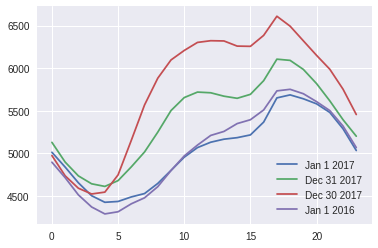

In [54]:
for i in range(2017,2018):
    plt.plot(df[(df.Year==i) & (df.Month==1) & (df.Day==1)]['N.Y.C.'].values, label = 'Jan 1 2017')
    plt.plot(df[(df.Year==i-1) & (df.Month==12) & (df.Day==31)]['N.Y.C.'].values, label = 'Dec 31 2017')
    plt.plot(df[(df.Year==i-1) & (df.Month==12) & (df.Day==30)]['N.Y.C.'].values, label = 'Dec 30 2017')
    plt.plot(df[(df.Year==i-1) & (df.Month==1) & (df.Day==1)]['N.Y.C.'].values, label = 'Jan 1 2016')
    plt.legend(loc = 'lower right')
plt.show()
